## Colab Set-up

In [ ]:
# import os
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# download = drive.CreateFile({'id': '1RvygCktOT1irquOzmXO90OyhcN2UoHMN'})
# download.GetContentFile('data.rar')

# !unrar x data.rar

In [119]:
# Imports
import os
import cv2
import random
import numpy as np

from load_data import *

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import keras
from keras import layers, regularizers, optimizers
from keras.applications.resnet50 import ResNet50
from keras import layers, models, regularizers, optimizers
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.layers import Flatten, Dense, Dropout
from keras.models import Model, Sequential
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint


from hyperopt import hp, fmin, tpe, STATUS_OK, STATUS_FAIL, Trials, space_eval, rand
from keras_tqdm import TQDMNotebookCallback 

### Import real fingerprint images

### Load the data

In [94]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.3) # set validation split

In [95]:
# Set train & test directories
train_dir = os.path.join(os.getcwd(), 'data', 'train')
test_dir = os.path.join(os.getcwd(), 'data', 'test')

In [96]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    subset='training') # set as training data

Found 1400 images belonging to 2 classes.


In [97]:
validation_generator = train_datagen.flow_from_directory(train_dir,
                                                         target_size=(224, 224),
                                                         batch_size=100,
                                                         class_mode='binary',
                                                         subset='validation')

Found 600 images belonging to 2 classes.


### Plotting

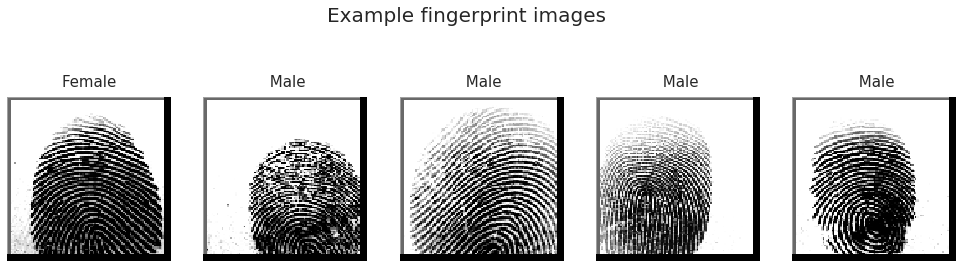

In [106]:
def plot_images(generator, title='Example fingerprint images'):
    # Reshape
#    X = np.array(X).reshape(len(X), 244,244)    
#     X = np.array(X).reshape(len(X), 103,96)
    
    fig, axes = plt.subplots(1, 5, figsize=(17, 5))
    
    for idx, ax in enumerate(axes):
        ax.axis('off')
        x, y = generator.next()
        index = random.randint(0, 9)
        ax.imshow(x[index])
        ax.set_title('Female' if y[index] == 0 else ' Male', size=15, pad=10)
    
    fig.suptitle(title, fontsize=20)

plot_images(train_generator)

### Plot training history

In [115]:
def plotHistory(History):
    '''Generates two plots: (1) the train accuracy vs. validation accuracy and (2) train loss vs. validation loss.'''
    sns.set(style='darkgrid', rc={'figure.figsize':(14,4)})
    data = History.history
    
    acc = data['accuracy']
    val_acc = data['val_accuracy']
    epochs = range(1, len(acc)+1)
    
    loss = data['loss']
    val_loss = data['val_loss']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))

    fig.suptitle('Train set vs. validation set', fontsize=16)
    
    ax1.plot(epochs, acc, 'b', label='train')
    ax1.plot(epochs, val_acc, 'r', label='val')
    ax1.set_title('Accuracy', fontsize=14)
    ax1.set_xlabel('Epoch')

    ax2.plot(epochs, loss, 'b', label='train')
    ax2.plot(epochs, val_loss, 'r', label='val')
    ax2.set_title('Loss', fontsize=14)
    ax2.set_xlabel('Epoch')
    
     # Add vertical line where accuracy is maximal
    ax1.axvline(x=val_acc.index(max(val_acc))+1, color='dimgrey', linestyle='--', label='max acc')
    ax2.axvline(x=val_loss.index(min(val_loss))+1, color='dimgrey', linestyle='--', label='min loss')
    
    ax1.legend()
    ax2.legend()

    plt.show()
    print('After {} epochs the maximum validation accuracy is {:.2%}'.format(val_acc.index(max(val_acc))+1, max(val_acc)))
    print('After {} epochs the maximum validation loss is {:.2f}'.format(val_loss.index(min(val_loss))+1, min(val_loss)))

### Transfer Learning

In [131]:
def create_embedding(trainable='none', 
                     dense_layers=1, 
                     dense_hidden_size=64,
                     dropout_rate=0, 
                     l1_reg=0, 
                     l2_reg=0, 
                     optimizer_function='SGD', 
                     learning_rate=0.001,
                     momentum=0,
                     nesterov=False,
                     decay=0,
                     print_model=False, 
                     **arg):
    """
    Builds neural network using pre-trained CNN model (ResNet50) with additional layers and returns configured model. 
    """
    
    # Instantiate VGG16 model (without dense layers)
    pre_trained_model = ResNet50(weights='imagenet', 
                                 include_top=False,
                                 input_shape=(224, 224, 3))
    
    # Freeze all layers in the imported CNN
    for layer in pre_trained_model.layers:
        layer.trainable = False
    
    # Unfreeze last conv layer from the imported CNN if we aim to train the last layer
    if trainable=='last_layer':
        pre_trained_model.layers[-2].trainable = True

    # Add flat layer after last layer from imported CNN
    flat_layer = Flatten()(pre_trained_model.output)
    
    add_layer = flat_layer
    
    for layer in range(dense_layers):
        add_layer = Dense(dense_hidden_size, activation='relu', 
                          kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg))(add_layer)
        
        if dropout_rate > 0:
            add_layer = Dropout(rate=dropout_rate)(add_layer)
        
    # Add output layer for classificaiton
    output_layer = Dense(1, activation='sigmoid')(add_layer)

    # Build new model structure
    model_final = Model(inputs=pre_trained_model.input, outputs=output_layer)
    
    if optimizer_function == 'adam':
        optimizer = optimizers.Adam(learning_rate=learning_rate)
        
    if optimizer_function == 'RMSprop':
        optimizer = optimizers.RMSprop(learning_rate=learning_rate)

    if optimizer_function == 'SGD':
        optimizer = optimizers.SGD(learning_rate=learning_rate, momentum=momentum, decay=decay, nesterov=nesterov)

        
    # Configure model for training
    model_final.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
    
    if print_model:
        model_final.summary()
    
    return model_final
    

In [133]:
resnet_frozen = create_embedding(trainable='none', 
                                 dense_layers=1, 
                                 dense_hidden_size=16,
                                 dropout_rate=0, 
                                 l1_reg=0, 
                                 l2_reg=0, 
                                 optimizer_function='SGD', 
                                 learning_rate=0.01,
                                 momentum=0.9,
                                 nesterov=False,
                                 decay=0.1,
                                 print_model=False)

/home/bernard/anaconda3/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [138]:
hist.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

In [135]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
progress = TQDMNotebookCallback(leave_inner=False)

# Store the keras callbacks
callbacks = [early_stopping, progress]

hist = resnet_frozen.fit_generator(train_generator,
                                   steps_per_epoch=train_generator.samples // 128,
                                   validation_data=validation_generator, 
                                   validation_steps=validation_generator.samples // 128,
                                   callbacks=callbacks,
                                   epochs=30,
                                   verbose=0)

KeyboardInterrupt: 

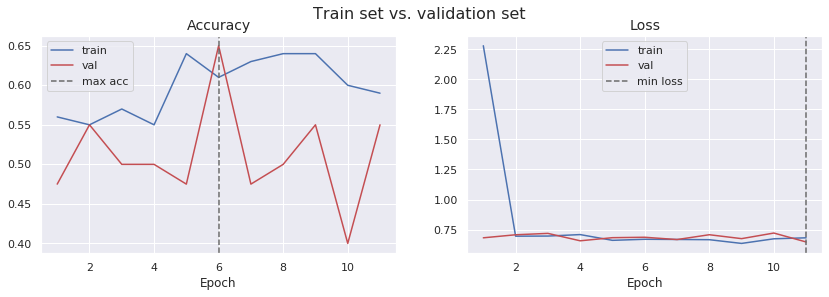

After 6 epochs the maximum validation accuracy is 65.00%
After 11 epochs the maximum validation loss is 0.65


In [124]:
plotHistory(hist)